# Inbuilt StereoSGBM

The disparity matrix does not contain any negative values.
Block Size:3 PreProcessing Algorithm:GS
	Recall = 6.00%


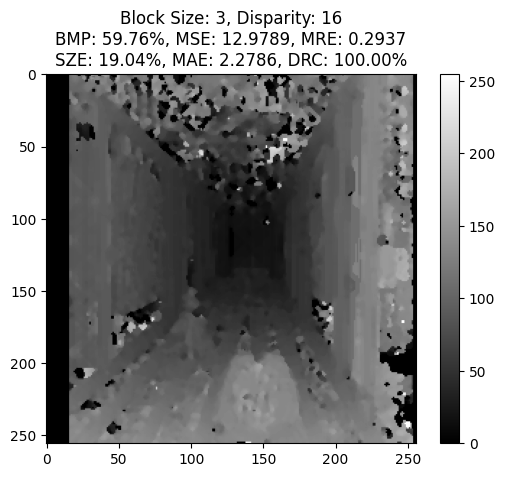

The disparity matrix does not contain any negative values.
Block Size:5 PreProcessing Algorithm:GS
	Recall = 6.05%


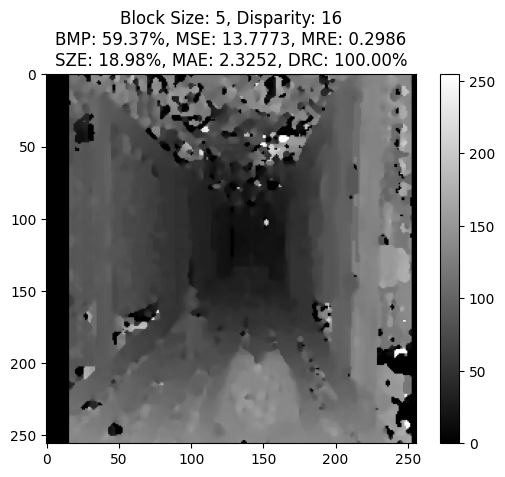

The disparity matrix does not contain any negative values.
Block Size:7 PreProcessing Algorithm:GS
	Recall = 6.32%


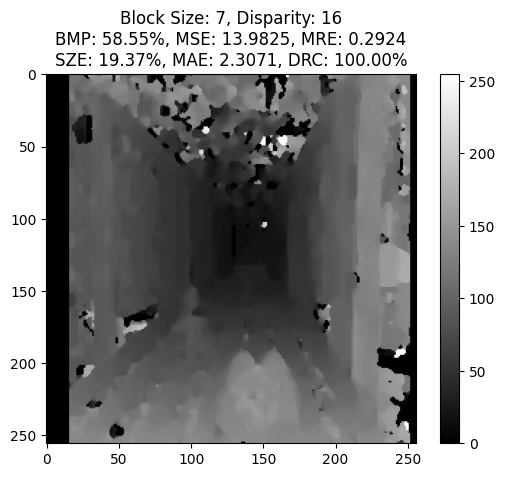

The disparity matrix does not contain any negative values.
Block Size:9 PreProcessing Algorithm:GS
	Recall = 6.16%


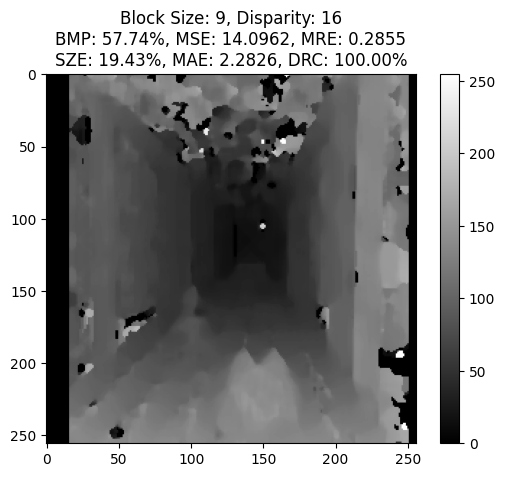

The disparity matrix does not contain any negative values.
Block Size:11 PreProcessing Algorithm:GS
	Recall = 6.17%


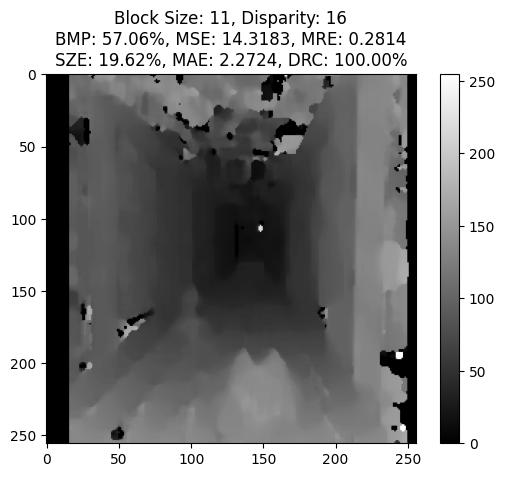

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img_left = cv2.imread('/content/corridorl.jpg', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('/content/corridorr.jpg', cv2.IMREAD_GRAYSCALE)
imgGroundTruth = cv2.imread('/content/GT.jpg', cv2.IMREAD_GRAYSCALE)
# img_left = cv2.imread('/content/conel.png', cv2.IMREAD_GRAYSCALE)
# img_right = cv2.imread('/content/coner.png', cv2.IMREAD_GRAYSCALE)
# imgGroundTruth = cv2.imread('/content/disp2.png', cv2.IMREAD_GRAYSCALE)
# img_left = cv2.imread('/content/tsukubal.jpg', cv2.IMREAD_GRAYSCALE)
# img_right = cv2.imread('/content/tsukubar.jpg', cv2.IMREAD_GRAYSCALE)


numDisparities = 16
mode = cv2.STEREO_SGBM_MODE_HH
numOfIMGChannel = 3
minDisparity = 0
block_sizes = [3, 5, 7, 9, 11]

def calculate_metrics(disparity, imgGroundTruth):
    disparity = disparity.astype(np.float32)/16.0
    imgGroundTruth = imgGroundTruth.astype(np.float32)/16.0

    valid_mask = imgGroundTruth > 0

    # BMP (Bad Matched Pixels)
    error_threshold = 1.0
    bmp = np.sum(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) > error_threshold) / np.sum(valid_mask)
    #print(f"BMP (Bad Matched Pixels): {bmp * 100:.2f}%")

    # MSE (Mean Squared Error)
    mse = np.mean((disparity[valid_mask] - imgGroundTruth[valid_mask]) ** 2)
    #print(f"MSE (Mean Squared Error): {mse:.4f}")

    # MRE (Mean Relative Error)
    mre = np.mean(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) / (np.abs(imgGroundTruth[valid_mask]) + 1e-5))
    #print(f"MRE (Mean Relative Error): {mre:.4f}")

    # SZE (Subpixel Zero Error)
    sze = np.sum(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]) < 0.5) / np.sum(valid_mask)
    #print(f"SZE (Subpixel Zero Error): {sze * 100:.2f}%")

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(disparity[valid_mask] - imgGroundTruth[valid_mask]))
    #print(f"MAE (Mean Absolute Error): {mae:.4f}")

    # DRC (Disparity Range Coverage)
    min_disparity = np.min(disparity[valid_mask])
    max_disparity = np.max(disparity[valid_mask])
    valid_disparities = (disparity >= min_disparity) & (disparity <= max_disparity)
    total_pixels = disparity.size
    covered_pixels = np.sum(valid_disparities)
    drc = (covered_pixels / total_pixels) * 100
    #print(f"DRC (Disparity Range Coverage): {drc:.2f}%")
    return bmp, mse, mre, sze, mae, drc

def calculate_metrics_2(disparity):
    # Ensure the disparity map is in float32 for precision
    disparity = disparity.astype(np.float32)/16.0

    # Create a valid mask (disparity > 0) to exclude invalid disparities
    valid_mask = disparity > 0

    # Calculate the minimum and maximum disparity from valid pixels only
    min_disparity = np.min(disparity[valid_mask])
    max_disparity = np.max(disparity[valid_mask])

    # Check if disparities are within the valid range
    valid_disparities = (disparity >= min_disparity) & (disparity <= max_disparity)

    # Calculate DRC (Disparity Range Coverage)
    total_pixels = np.sum(valid_mask)  # Only consider valid disparity pixels
    covered_pixels = np.sum(valid_disparities)  # Pixels within the valid range
    drc = (covered_pixels / total_pixels) * 100

    #print(f"DRC (Disparity Range Coverage): {drc:.2f}%")
    return drc

# Apply Histogram Equalization (ensure input is grayscale and 8-bit)
def apply_histogram_equalization(img):
    if img.dtype != np.uint8:
        img = cv2.convertScaleAbs(img)  # Convert to 8-bit if not already
    if len(img.shape) == 2:  # Only apply HE if the image is grayscale
        return cv2.equalizeHist(img)
    else:
        raise ValueError("Histogram Equalization only works on single-channel grayscale images")

# Apply Gaussian Smoothing
def apply_gaussian_smoothing(img, kernel_size=(5, 5), sigma=1.5):
    return cv2.GaussianBlur(img, kernel_size, sigma)

def preprocessing(img_left, img_right,algo='HE'):
  if algo=='HE':
    img_left = apply_histogram_equalization(img_left)
    img_right = apply_histogram_equalization(img_right)
  elif algo=='GS':
    img_left = apply_gaussian_smoothing(img_left)
    img_right = apply_gaussian_smoothing(img_right)
  elif algo=='HEGS':
    img_left = apply_histogram_equalization(img_left)
    img_right = apply_histogram_equalization(img_right)
    img_left = apply_gaussian_smoothing(img_left)
    img_right = apply_gaussian_smoothing(img_right)
  elif algo=='Normal':
    return img_left, img_right
  return img_left, img_right

def get_recall(disparity, gt):
    """
    computes the recall of the disparity map.
    :param disparity: disparity image.
    :param gt: path to ground-truth image.
    :param args: program arguments.
    :return: rate of correct predictions.
    """
    correct = np.count_nonzero(np.abs(disparity - gt) <= 3)
    return float(correct) / gt.size

def stereoSGB(blockSize,numDisparities,minDisparity,mode,numOfIMGChannel,img_left,img_right,GT,algo):
    #Preprocessing
    img_left, img_right = preprocessing(img_left, img_right,algo)

    # Create a StereoBM object
    stereo = cv2.StereoSGBM_create(
        minDisparity=minDisparity,
        numDisparities=numDisparities,
        blockSize=blockSize,
        mode=mode
    )

    # Compute the disparity map
    disparity = stereo.compute(img_left, img_right)

    # Handle negative disparity values (set them to 0)
    disparity[disparity < 0] = 0

    # Check if there are any negative values
    has_negatives = np.any(disparity < 0)

    # Print result
    if has_negatives:
        print("The disparity matrix contains negative values.")
        negative_count = np.sum(disparity < 0)
        print(f"Number of negative values: {negative_count}")
    else:
        print("The disparity matrix does not contain any negative values.")

    # Normalize the disparity map for better visualization
    disparity = cv2.normalize(disparity, disparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disparity = np.uint8(disparity)

    print(f"Block Size:{blockSize} PreProcessing Algorithm:{algo}")
    # Calculate and print metrics
    bmp, mse, mre, sze, mae, drc = calculate_metrics(disparity, GT)
    recall = get_recall(disparity, GT)
    print('\tRecall = {:.2f}%'.format(recall * 100.0))
    plt.imshow(disparity, cmap='gray')
    plt.title(f"Block Size: {blockSize}, Disparity: {numDisparities}\n"
        f"BMP: {bmp * 100:.2f}%, MSE: {mse:.4f}, MRE: {mre:.4f}\n"
        f"SZE: {sze * 100:.2f}%, MAE: {mae:.4f}, DRC: {drc:.2f}%")
    plt.colorbar()
    plt.show()

def stereoSGB_2(blockSize,numDisparities,minDisparity,mode,numOfIMGChannel,img_left,img_right,algo):
    #Preprocessing
    img_left, img_right = preprocessing(img_left, img_right,algo)

    # Create a StereoBM object
    stereo = cv2.StereoSGBM_create(
        minDisparity=minDisparity,
        numDisparities=numDisparities,
        blockSize=blockSize,
        mode=mode
    )

    # Compute the disparity map
    disparity = stereo.compute(img_left, img_right)

    # Handle negative disparity values (set them to 0)
    disparity[disparity < 0] = 0

    # Check if there are any negative values
    has_negatives = np.any(disparity < 0)

    # Print result
    if has_negatives:
        print("The disparity matrix contains negative values.")
        negative_count = np.sum(disparity < 0)
        print(f"Number of negative values: {negative_count}")
    else:
        print("The disparity matrix does not contain any negative values.")

    # Normalize the disparity map for better visualization
    disparity = cv2.normalize(disparity, disparity, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disparity = np.uint8(disparity)

    print(f"Block Size:{blockSize} PreProcessing Algorithm:{algo}")
    # Calculate and print metrics
    drc = calculate_metrics_2(disparity)

    # Show the disparity map
    plt.imshow(disparity, cmap='gray')
    plt.title(f"Block Size: {blockSize}, Disparity: {numDisparities}, DRC: {drc:.2f}%")
    plt.colorbar()
    plt.show()



for blockSize in block_sizes:
    stereoSGB(blockSize,numDisparities,minDisparity,mode,numOfIMGChannel,img_left,img_right,imgGroundTruth,algo='GS')
    # stereoSGB(blockSize,numDisparities,minDisparity,mode,numOfIMGChannel,img_left,img_right,imgGroundTruth,algo='HE')
    # stereoSGB(blockSize,numDisparities,minDisparity,mode,numOfIMGChannel,img_left,img_right,imgGroundTruth,algo='HEGS')
    #stereoSGB(blockSize,numDisparities,minDisparity,mode,numOfIMGChannel,img_left,img_right,imgGroundTruth,algo='Normal')

# Block Size:9 (Gaussian Smoothing)

The disparity matrix does not contain any negative values.
Block Size:11 PreProcessing Algorithm:GS


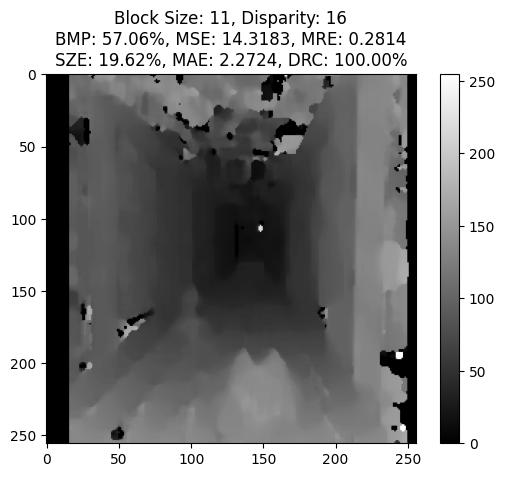

In [ ]:
blockSizes= [11]
img_left= cv2.imread('/content/corridorl.jpg', cv2.IMREAD_GRAYSCALE)
img_right= cv2.imread('/content/corridorr.jpg', cv2.IMREAD_GRAYSCALE)

for blockSize in blockSizes:
  stereoSGB(blockSize,numDisparities,minDisparity,mode,numOfIMGChannel,img_left,img_right,imgGroundTruth,algo='GS')

The disparity matrix does not contain any negative values.
Block Size:11 PreProcessing Algorithm:GS


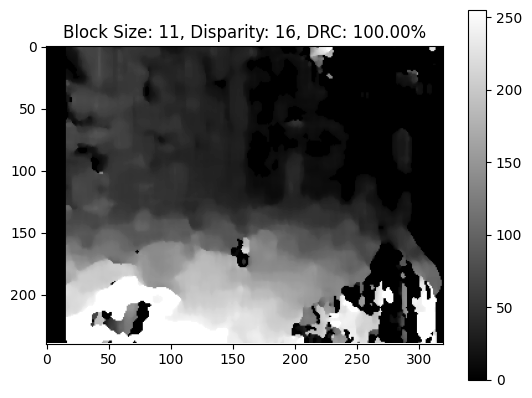

In [ ]:
blockSizes= [11]
img_left= cv2.imread('/content/triclopsi2l.jpg', cv2.IMREAD_GRAYSCALE)
img_right= cv2.imread('/content/triclopsi2r.jpg', cv2.IMREAD_GRAYSCALE)

for blockSize in blockSizes:
  stereoSGB_2(blockSize,numDisparities,minDisparity,mode,numOfIMGChannel,img_left,img_right,algo='GS')